# Week 3 
## Data Normalization, Unsupervised Learning, Confusion matrix

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('./heart_failure_clinical_records_dataset.csv') #make sure to replace with your data directory
#df.drop(columns=['time'],inplace=True) #drop the time column which is not one of the informative features 
df_features = df.iloc[:,:-1]
df_target = df['DEATH_EVENT']

In [2]:
df_features

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


In [3]:
df_target

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

In [9]:
df_target.value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

In [7]:
df_target.value_counts(normalize=True)

DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64

In [10]:
df_features.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

# Data Normalization 

$$z = \frac{x - \mu}{\sigma}$$

z: zscore

$\mu$: average value 

$\sigma$: standard deviation 

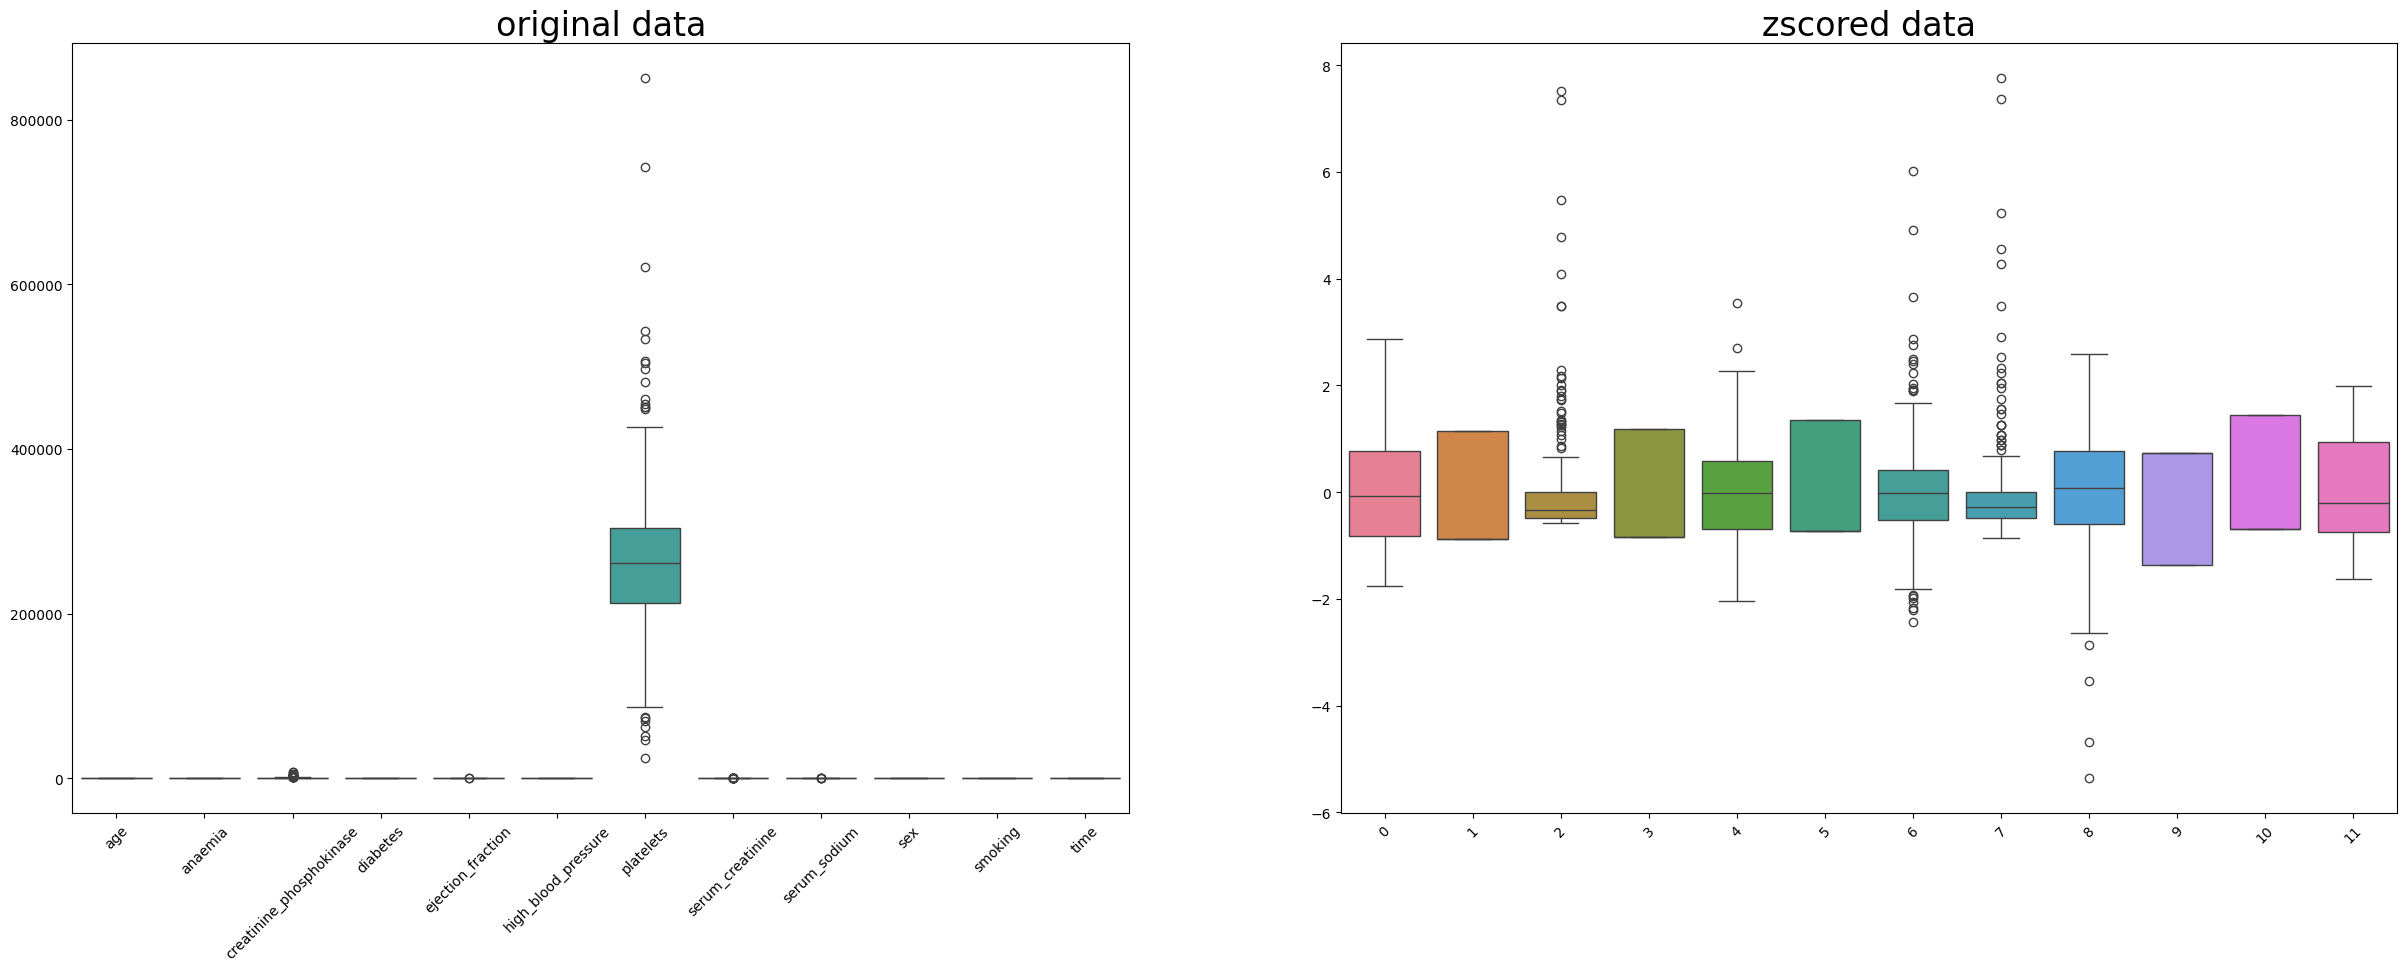

In [21]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df_features_zscored = stats.zscore(df_features)
#plot both data including original and normalized
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.boxplot(df_features)
plt.title('original data',size=24)
plt.xticks(rotation=45);  # Rotate x-ticks by 45 degrees

plt.subplot(1,2,2)
sns.boxplot(df_features_zscored)
plt.title('zscored data', size = 24);
plt.xticks(rotation=45);  # Rotate x-ticks by 45 degrees


#plt.savefig('/Users/bonakdar/Desktop/org_zscore.png')

# Principal component analysis (PCA

$X \sim Z.W^T$

X: original data

$Z.W^T$: reconstructed data

Goal: find a W (projection matrix) that minimizes the error between X and $Z.W^T$

In [63]:
from sklearn.decomposition import PCA
#PCA
pca = PCA(n_components=3)
pca = pca.fit(df_features_zscored)
y= pca.fit_transform(df_features_zscored)
loadings = pca.components_.T

In [28]:
pca.explained_variance_

array([1.66854625, 1.5843945 , 1.27239806])

In [29]:
pca.explained_variance_ratio_

array([0.13858049, 0.13159129, 0.10567855])

In [27]:
pca.components_.shape

(3, 12)

In [32]:
pca.n_components_

3

In [41]:
y.shape

(299, 3)

# loadings value: how strongly each feature contributes to each principal component

In [66]:
loadings.shape

(12, 3)

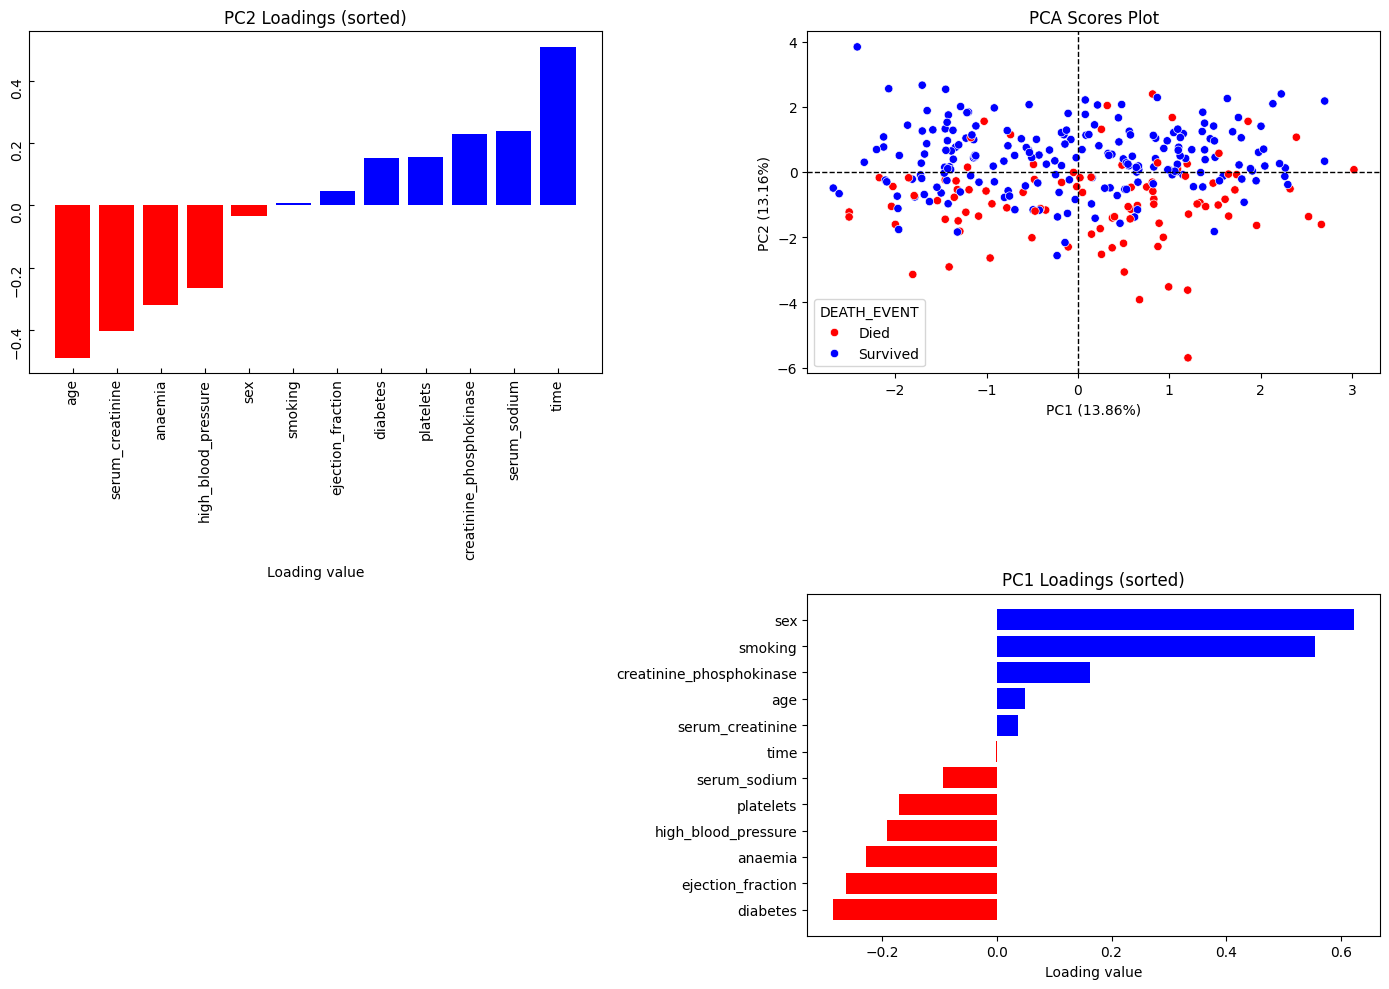

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

loadings = pca.components_.T
feature_names = df_features.columns

# Prepare loadings
pc1_loadings = pd.Series(loadings[:, 0], index=feature_names).sort_values()
pc2_loadings = pd.Series(loadings[:, 1], index=feature_names).sort_values()

pc1_colors = ['red' if v < 0 else 'blue' for v in pc1_loadings]
pc2_colors = ['red' if v < 0 else 'blue' for v in pc2_loadings]

# ---- Create subplots ----
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# (0,0) PC2 loadings
axes[0,0].bar(pc2_loadings.index, pc2_loadings.values, color=pc2_colors)
axes[0,0].set_title('PC2 Loadings (sorted)')
axes[0,0].set_xlabel('Loading value')
axes[0,0].tick_params(axis='both', direction='in',rotation=90)

# (0,1) Scores plot
color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(x=y[:,0], y=y[:,1], hue=df_target.map({1: 'Died', 0: 'Survived'}), ax=axes[0,1], palette=color_mapping)
axes[0,1].axhline(0, linestyle='--', linewidth=1, color='black')
axes[0,1].axvline(0, linestyle='--', linewidth=1, color='black')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
axes[0,1].set_title('PCA Scores Plot')

# (1,1) PC1 loadings
axes[1,1].barh(pc1_loadings.index, pc1_loadings.values, color=pc1_colors)
axes[1,1].set_title('PC1 Loadings (sorted)')
axes[1,1].set_xlabel('Loading value')

# (1,0) Empty subplot
axes[1,0].axis('off')

plt.tight_layout()
plt.show()

# Exercise: Run the PCA on non normalized data. What do you see and why it happens?

In [77]:
#write your code here



# Exercise: Run the PCA on normalized data but this time exclude the 'time' column. 

In [83]:
#write your code here



,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


# Kmeans

In [148]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('./heart_failure_clinical_records_dataset.csv') #make sure to replace with your data directory
#df.drop(columns=['time'],inplace=True) #drop the time column which is not one of the informative features 
df_features = df.iloc[:,:-1]
df_target = df['DEATH_EVENT']
# exclude the time column in df_features
df_features = df_features.drop(columns=['time'])
#normalize the data
from scipy import stats
df_features_normalized = stats.zscore(df_features)
df_features_normalized = pd.DataFrame(df_features_normalized, columns=df_features.columns)


#KMEANS
from sklearn.cluster import KMeans

# KMeans on scaled feature space (NOT PCA)
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(df_features_normalized)
clusters
# Save labels
df_features_normalized['Cluster'] = clusters
df_features_normalized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Cluster
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,0
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,0
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,0
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,0
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,0


/opt/anaconda3/envs/vmb_env_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


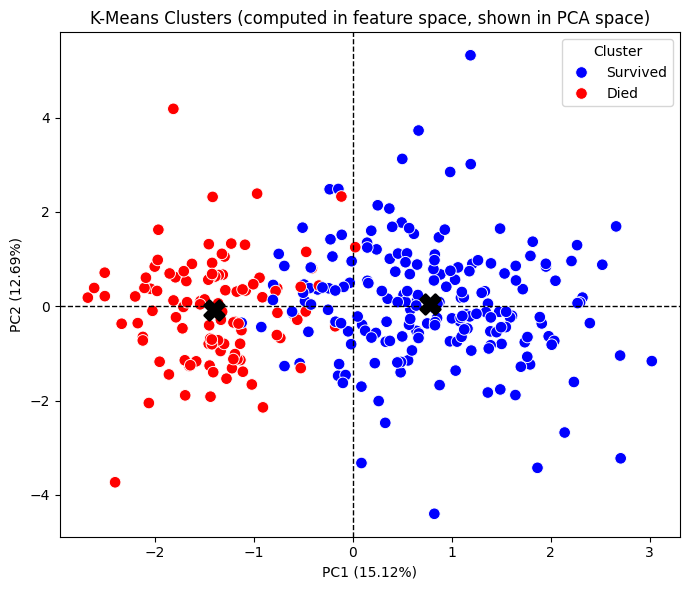

In [149]:
#pca 
from sklearn.decomposition import PCA
#PCA
pca = PCA(n_components=3)
pca = pca.fit(df_features_normalized.iloc[:,:-1])
y= pca.fit_transform(df_features_normalized.iloc[:,:-1])

plt.figure(figsize=(7,6))

color_mapping = {'Died': 'r', 'Survived': 'b'}
sns.scatterplot(
    x=y[:,0],
    y=y[:,1],
    hue=df_features_normalized['Cluster'].map({1: 'Died', 0: 'Survived'}), palette=color_mapping,
    s=70
)

# Transform cluster centers into PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, linewidth=2, color='black')

plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.axvline(0, linestyle='--', linewidth=1, color='black')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('K-Means Clusters (computed in feature space, shown in PCA space)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

[Text(0, 0.5, 'Survived'), Text(0, 1.5, 'Died')]

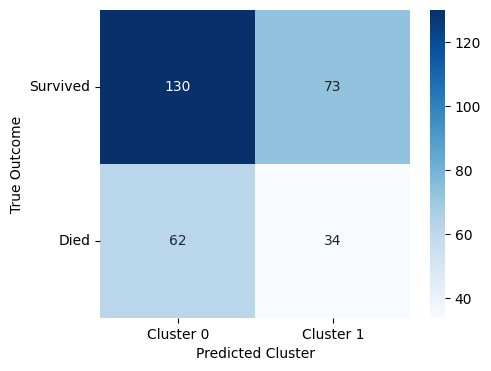

In [150]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_target, clusters)
import seaborn as sns
#sns.heatmap(cm,annot=True)

plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

ax.set_xlabel('Predicted Cluster')
ax.set_ylabel('True Outcome')
ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
ax.set_yticklabels(['Survived', 'Died'], rotation=0)


# How to identify the optimal number of K?

Silhouette score = $\frac{b-a}{max(a,b)}$

For each datapoint: 

a: distance to points in the same cluster

b: distance to points in other clusters

silhouette score = 1 --> perfect clustering

silhouette score < 0.25 --> weak clustering 



In [160]:
df_features_normalized

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Cluster
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,0
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,0
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,0
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,0
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,0


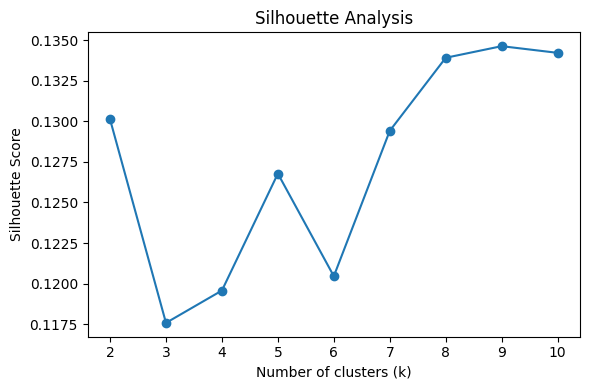

In [164]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
sil_scores = []
K = range(2, 11)   # silhouette requires at least 2 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(df_features_normalized.iloc[:,:-1])
    
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(df_features_normalized.iloc[:,:-1], labels))

plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()


# Exercise: Run Kmeans with another K value, and plot for top 2 features identified from last week. 

## You should make a scatter plot, x-axis is one feature, y-axis is another, color them based on cluster label.

In [168]:
# write your code here






# run k-means with k=2, make 2 subplots for top 2 features, one color them with real labels (target values), another with cluster label. 

In [167]:
# write your code here






# Practice for home: Run the statistical analysis we worked on in week 2 with the normalized data. is there any difference? why or why not?  